# Unloading Manuscript
## Figures 7 and 8 
## Step 1: Manual Computation of the PDPs

created by Cassie Lumbrazo\
date: Jan 2026\
python environment: **randomforest**

latest: running on UAS linux machine


## Load Everything

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle
import sklearn

import matplotlib

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.inspection import PartialDependenceDisplay

# Load model and set up for plotting

In [3]:
from joblib import dump
from joblib import load

filepath = '/home/cassie/data/unloading_regimes_analysis/'
model = load(filepath + 'updated_analysis_random_forest_model_int_20_1000_flip.joblib') # load the random forest model

In [4]:
model

RandomForestClassifier(max_depth=3, n_estimators=1000, n_jobs=15)

Also can load the new pickle file now that the it works with the new python environment and such, 

In [5]:
# model_pickle = pickle.load(open(filepath + 'updated_analysis_random_forest_model_int_20_1000_flip.pkl', 'rb')) # rb, reading
# model_pickle

In [6]:
df = pd.read_csv(filepath + 'updated_analysis_random_forest_model_int_20_1000_results_with_metdata.csv')
df

,Unnamed: 0,shortwave,windspeed,temp,CD,Classification,site,model
0,0,4.930000,1.180000,-3.495000,1.0,Snow Staying,niwot,1
1,1,29.430000,1.735000,-3.325000,1.0,Snow Staying,niwot,1
2,2,124.500000,2.080000,-2.430000,1.0,Snow Staying,niwot,1
3,3,102.040000,2.745000,-3.250000,1.0,Snow Staying,niwot,1
4,4,614.380000,4.595000,-3.350000,1.0,Snow Staying,niwot,0
...,...,...,...,...,...,...,...,...
1645,1645,400.306250,0.770125,2.143021,1.0,Snow Staying,laret,0
1646,1646,605.846250,0.973554,3.865325,1.0,Snow Staying,laret,0
1647,1647,854.292500,1.648042,4.049008,0.0,Snow Unloading,laret,0
1648,1648,902.823333,1.427383,4.768171,0.0,Snow Unloading,laret,0


In [7]:
# load the features used in the model
local_path='/home/cassie/data/unloading_regimes_analysis/'
X_features = pd.read_csv(local_path + "X_randomforestmodel_features.csv")
y_features = pd.read_csv(local_path + "y_randomforestmodel_features.csv")

In [8]:
X_features

,shortwave radiation (W/m2),wind speed (m/s),air temperature (C)
0,4,1,-3
1,29,1,-3
2,124,2,-2
3,102,2,-3
4,614,4,-3
...,...,...,...
1645,400,0,2
1646,605,0,3
1647,854,1,4
1648,902,1,4


In [9]:
# print the min and max for each feature in the model
for col in X_features.columns:
    print(f"{col}: min={X_features[col].min()}, max={X_features[col].max()}")

shortwave radiation (W/m2): min=0, max=1106
wind speed (m/s): min=0, max=14
air temperature (C): min=-36, max=7


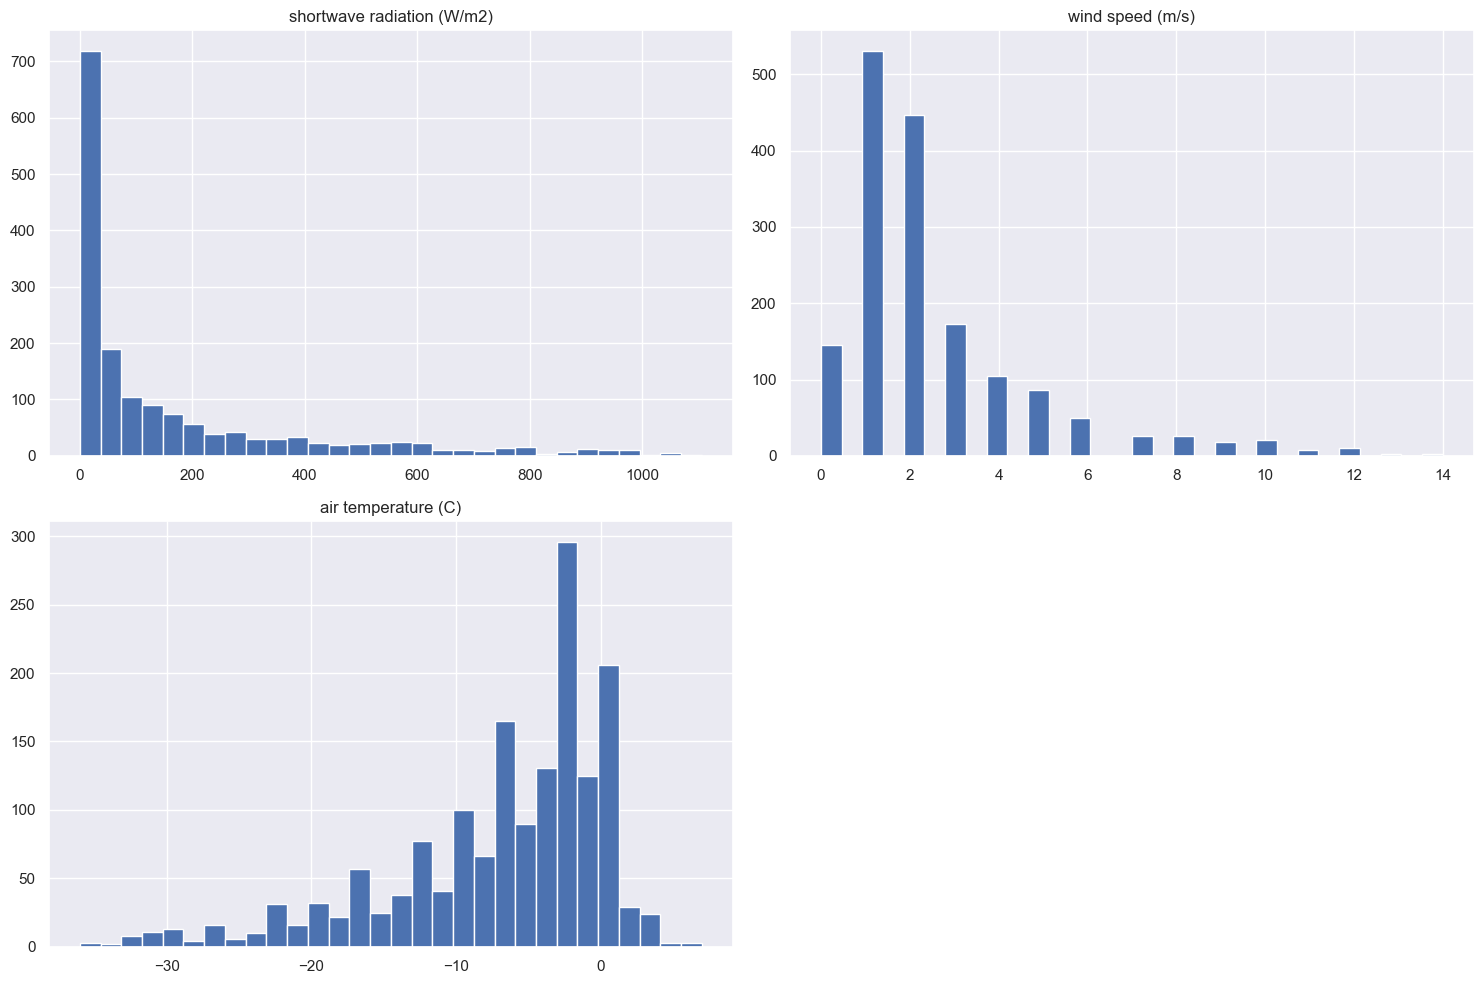

In [10]:
# plot a histogram of all the features in the model to see their distributions
X_features.hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

In [9]:
print(X_features.shape)

(1650, 3)


In [10]:
model

RandomForestClassifier(max_depth=3, n_estimators=1000, n_jobs=15)

In [11]:
print("Shape of X_features:", X_features.shape)
print("Columns:", X_features.columns)

Shape of X_features: (1650, 3)
Columns: Index(['shortwave radiation (W/m2)', 'wind speed (m/s)',
       'air temperature (C)'],
      dtype='object')


In [12]:
nametemperature_fig = "air temperature (℃)"
namewindspeed_fig = "wind speed (ms⁻¹)"
nameshortwave_fig = "shortwave radiation (Wm⁻²)"

nametemperature = "air temperature (C)"
namewindspeed = "wind speed (m/s)"
nameshortwave = "shortwave radiation (W/m2)"

# temperature_limits = (-25, 3)
# shortwave_limits = (-5, 700)
# windspeed_limits = (0, 20)

In [13]:
features_info = {
    "features": [
        nameshortwave, 
        nametemperature,
        [nameshortwave, nametemperature]   # 2-way PDP
    ],
    "kind": "average"
}


# Calculate the PDPs Manually

### Function for manual PDP computation

In [11]:
from joblib import Parallel, delayed

In [14]:
def compute_pdp_1d(model, X, feature, grid):
    """
    Compute 1-way PDP for a single feature.
    """
    X_temp = X.copy()
    pdp = []

    for val in grid:
        X_temp[feature] = val
        preds = model.predict_proba(X_temp)[:, 1]
        pdp.append(preds.mean())

    return np.array(pdp)


def compute_pdp_2d(model, X, feature_x, feature_y, grid_x, grid_y):
    """
    Compute 2-way PDP for two features.
    """
    X_temp = X.copy()
    Z = np.zeros((len(grid_y), len(grid_x)))

    for i, y in enumerate(grid_y):
        for j, x in enumerate(grid_x):
            X_temp[feature_x] = x
            X_temp[feature_y] = y
            preds = model.predict_proba(X_temp)[:, 1]
            Z[i, j] = preds.mean()

    return Z

### Define shared grids and limits between figures

> Need to define ranges for calculations, 
temp: [-36,7], select [-35,5]\
sw:   [0,1106], select [0,1000]\
wind: [0,14], select [0,14]


In [ ]:
# Axis limits (explicit, publication-controlled)
grid = 500 # the code we ran at first used 80 here, so it needs to match the manual_compute script
temp_grid  = np.linspace(-35, 5, grid) # so the grid we are using is 80, but maybe that is not fine enough. Let's refine it more to 300-500
sw_grid    = np.linspace(0, 1000, grid)
wind_grid  = np.linspace(0, 14, grid)

# Color scale (shared across all 2-way plots)
vmin, vmax = 0.15, 0.60
levels = np.linspace(vmin, vmax, 12)


### Compute all the PDPs for Figure 7

In [17]:
# 1-way PDPs
pdp_temp  = compute_pdp_1d(model, X_features, "air temperature (C)", temp_grid)
pdp_sw    = compute_pdp_1d(model, X_features, "shortwave radiation (W/m2)", sw_grid)
pdp_wind  = compute_pdp_1d(model, X_features, "wind speed (m/s)", wind_grid)

# 2-way PDPs
pdp_temp_sw   = compute_pdp_2d(model, X_features,
                               "air temperature (C)", "shortwave radiation (W/m2)",
                               temp_grid, sw_grid)

pdp_temp_wind = compute_pdp_2d(model, X_features,
                               "air temperature (C)", "wind speed (m/s)",
                               temp_grid, wind_grid)

pdp_sw_wind   = compute_pdp_2d(model, X_features,
                               "shortwave radiation (W/m2)", "wind speed (m/s)",
                               sw_grid, wind_grid)


### Compute the PDPs for Figure 8

Set up subset of the data

In [18]:
X_cold = X_features[X_features["air temperature (C)"] < 0].copy()
X_warm = X_features[X_features["air temperature (C)"] >= 0].copy()

Then compute the stratified 2-way PDPs 

In [19]:
pdp_sw_wind_cold = compute_pdp_2d(
    model,
    X_cold,
    "shortwave radiation (W/m2)",
    "wind speed (m/s)",
    sw_grid,
    wind_grid
)

pdp_sw_wind_warm = compute_pdp_2d(
    model,
    X_warm,
    "shortwave radiation (W/m2)",
    "wind speed (m/s)",
    sw_grid,
    wind_grid
)


And save the output to open in another script for plotting, 

In [ ]:
np.savez(
    # "/home/cassie/python/repos/unloading_regimes_analysis/manuscript_figures/manual_pdp_figure_7_8_grid80_reducedlim.npz",
    "/home/cassie/python/repos/unloading_regimes_analysis/manuscript_figures/manual_pdp_figure_7_8_grid500.npz",
    temp_grid=temp_grid,
    sw_grid=sw_grid,
    wind_grid=wind_grid,
    pdp_temp=pdp_temp,
    pdp_sw=pdp_sw,
    pdp_wind=pdp_wind,
    pdp_temp_sw=pdp_temp_sw,
    pdp_temp_wind=pdp_temp_wind,
    pdp_sw_wind=pdp_sw_wind,
    pdp_sw_wind_cold=pdp_sw_wind_cold, # figure 8
    pdp_sw_wind_warm=pdp_sw_wind_warm  # figure 8
)

Then when we want to open that in another notebook, 

In [ ]:
# data = np.load("manual_pdp_figure_7_8_80points.npz")
# pdp_temp = data["pdp_temp"] -->

... doing this inside the next notebook, `Figures_7_8_manual_plot.ipynb`